# Detecting Waldo and Wilma: A Feature Extraction Approach

In this project, we're employing **Histogram Of Gradient (HOG)** and **Scale-invariant Feature Transform (SIFT)** algorithms to detect the positions of Waldo and Wilma. Our goal is to evaluate the feasibility of this approach before moving to deep neural networks.

## Feature Extraction Methods Employed

- **Image Types Used**:
  - Utilized both gray-scale and color images.

- **Binary Classification**:
  - Focused on both Waldo and Wilma for classification.

- **HOG (Histogram Of Gradients)**:
  - Chosen for its computational efficiency and lower memory requirements compared to SIFT.
  - Implemented in two forms:
    - HOG vectors.
    - Differences in HOG vectors.

- **SIFT (Scale-invariant Feature Transform)**:
  - Effective in extracting features accurately, regardless of image resizing.
  - Limited to gray-scale image processing.

- **K-means and PCA (Principal Component Analysis)**:
  - Employed for further feature refinement.

- **Data Augmentation**:
  - Tested with various characters to find optimized shapes for this code.

- **SURF (Speeded Up Robust Features)**:
  - Also experimented with, but not included due to patent constraints.


##Mount drive

In [ ]:
#drive mounted
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Import libraries

In [ ]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage import exposure
from google.colab.patches import cv2_imshow
import os
import glob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

##Background image data

In [ ]:
# Assuming you have corresponding ground truth bounding boxes in a dictionary
waldo_ground_truth_bboxes = {
    "image_101.png": (400, 164, 455, 272),
    "image_103.png": (64, 56, 119, 164),
    "image_105.png": (284, 116, 339, 224),
    "image_106.png": (168, 224, 223, 332),
    "image_108.png": (112, 80, 167, 188),
    "image_112.png": (364, 4, 419, 112),
    "image_120.png": (292, 180, 347, 288),
    "image_122.png": (12, 92, 67, 200),
    "image_123.png": (124, 72, 179, 180),
    "image_124.png": (396, 172, 451, 280),
    "image_133.png": (388, 120, 443, 228),
    "image_136.png": (368, 44, 423, 152),
    "image_138.png": (28, 188, 83, 296),
    "image_139.png": (60, 176, 115, 284),
    "image_146.png": (304, 88, 359, 196),
    "image_147.png": (408, 208, 463, 316),
    "image_149.png": (244, 204, 299, 312),
    "image_150.png": (312, 44, 367, 152),
    "image_152.png": (104, 76, 159, 184),
    "image_153.png": (172, 4, 227, 112),
    "image_154.png": (264, 132, 319, 240),
    "image_155.png": (268, 60, 323, 168),
    "image_156.png": (124, 152, 179, 260),
    "image_157.png": (112, 172, 167, 280),
    "image_158.png": (108, 184, 163, 292),
    "image_161.png": (372, 0, 427, 108),
    "image_164.png": (268, 88, 323, 196),
    "image_165.png": (288, 128, 343, 236),
    "image_167.png": (272, 144, 327, 252),
    "image_168.png": (176, 100, 231, 208),
}
wilma_ground_truth_bboxes = {
    "image_100.png": (328, 208, 386, 313),
    "image_102.png": (392, 20, 447, 137),
    "image_104.png": (384, 52, 439, 169),
    "image_107.png": (364, 152, 419, 269),
    "image_109.png": (300, 4, 355, 121),
    "image_110.png": (284, 68, 339, 185),
    "image_111.png": (192, 68, 247, 185),
    "image_113.png": (116, 188, 171, 305),
    "image_114.png": (296, 0, 351, 117),
    "image_115.png": (368, 140, 423, 257),
    "image_116.png": (112, 208, 167, 325),
    "image_117.png": (304, 164, 359, 281),
    "image_118.png": (228, 216, 283, 333),
    "image_119.png": (52, 188, 107, 305),
    "image_121.png": (48, 192, 103, 309),
    "image_125.png": (220, 8, 275, 125),
    "image_126.png": (192, 28, 247, 145),
    "image_127.png": (68, 72, 123, 189),
    "image_128.png": (56, 96, 111, 213),
    "image_129.png": (396, 52, 451, 169),
    "image_130.png": (324, 184, 379, 301),
    "image_131.png": (328, 48, 383, 165),
    "image_132.png": (160, 208, 215, 325),
    "image_134.png": (120, 96, 175, 213),
    "image_135.png": (336, 32, 391, 149),
    "image_137.png": (276, 200, 331, 317),
    "image_143.png": (356, 12, 411, 129),
    "image_145.png": (116, 84, 171, 201),
    "image_148.png": (212, 132, 267, 249),
    "image_151.png": (364, 212, 419, 329),
}

##Calculate bounding box

In [ ]:
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

##Get features using HOG and SIFT

In [ ]:
def get_hog_features(image, orientations, pixels_per_cell, cells_per_block):
    if image.ndim == 2:
        # Grayscale image
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                            cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=True)
    else:
        # Color/multichannel image
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                            cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=True,
                            multichannel=True, channel_axis=-1)
    return fd, hog_image

def get_sift_features(image, sigma=1.6, nOctaveLayers=3):
    sift = cv2.SIFT_create(nfeatures=0, nOctaveLayers=nOctaveLayers, contrastThreshold=0.04, edgeThreshold=10, sigma=sigma)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    sift_image = cv2.drawKeypoints(image, keypoints, None)

    return keypoints, descriptors, sift_image

##Test functions of HOG

In [ ]:
def find_waldo_hog(image_path, character_template_path, ground_truth_bbox, image_color, hog_diff_threshold=100):
    if image_color == "gray": # Grayscale image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        character_template = cv2.imread(character_template_path, cv2.IMREAD_GRAYSCALE)
    else: # Color image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        character_template = cv2.imread(character_template_path, cv2.IMREAD_COLOR)

    character_template_features, character_template_hog = get_hog_features(character_template , **hog_params)
    image_features, image_hog = get_hog_features(image, **hog_params)

    image_hog = image_hog.astype(np.float32)
    character_template_hog = character_template_hog.astype(np.float32)

    result = cv2.matchTemplate(image_hog, character_template_hog, cv2.TM_CCOEFF_NORMED)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    top_left = max_loc
    bottom_right = (top_left[0] + character_template.shape[1], top_left[1] + character_template.shape[0])

    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

    # Rescale HOG images for better visualization
    image_hog_rescaled = exposure.rescale_intensity(image_hog, in_range=(0, 10))
    character_template_hog_rescaled = exposure.rescale_intensity(character_template_hog, in_range=(0, 10))

    # Convert HOG images to the same data type as the original images
    image_hog_rescaled = (image_hog_rescaled * 255).astype(np.uint8)
    character_template_hog_rescaled = (character_template_hog_rescaled * 255).astype(np.uint8)

    # Overlay HOG images on the original images
    if image_color == "gray": # Grayscale image
      image_overlay = cv2.addWeighted(image, 0.7, image_hog_rescaled, 0.3, 0)
      character_template_overlay = cv2.addWeighted(character_template, 0.7, character_template_hog_rescaled, 0.3, 0)
    else: # Color image
      image_overlay = cv2.addWeighted(image, 0.7, cv2.cvtColor(image_hog_rescaled, cv2.COLOR_GRAY2BGR), 0.3, 0)
      character_template_overlay = cv2.addWeighted(character_template, 0.7, cv2.cvtColor(character_template_hog_rescaled, cv2.COLOR_GRAY2BGR), 0.3, 0)

    # Show the HOG images overlayed on the original images
    print("HOG overlay on the main image and character template:")
    cv2_imshow(image_overlay)
    cv2_imshow(character_template_overlay)

    # Print the HOG descriptors
    print("\nHOG descriptor of the main image:")
    print(image_features)
    print("\nHOG descriptor of the charater template:")
    print(character_template_features)

    # Extract the matched sub-image
    matched_sub_image = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

    # Calculate the HOG descriptor for the matched sub-image
    matched_sub_image_features, _ = get_hog_features(matched_sub_image, **hog_params)

    # Calculate the difference between the HOG descriptors
    hog_diff = np.linalg.norm(matched_sub_image_features - character_template_features)
    print(hog_diff )

    # Plot the histogram of the HOG features for the cropped image and the character template
    plt.hist(matched_sub_image_features, bins=200, range=(0, 1), alpha=0.5, label='Detected image')
    plt.hist(character_template_features, bins=200, range=(0, 1), alpha=0.5, label='Character image')
    plt.xlabel('Gradient orientation')
    plt.ylabel('Frequency')
    plt.yscale("log")
    plt.xscale("log")
    plt.title('Histogram of HOG features for detected and character images')
    plt.legend()
    plt.show()

    # Check if the difference exceeds the threshold
    if hog_diff > hog_diff_threshold:
        print(f"HOG difference: {hog_diff} (exceeds threshold)")
        print(f"This is a different character!")
        return False

    # Show the result
    print("\nResult:")

    predicted_bbox = (top_left[0], top_left[1], bottom_right[0], bottom_right[1])
    iou = calculate_iou(predicted_bbox, ground_truth_bbox)

    print(f"Predicted bounding box: {predicted_bbox}")
    if iou < 0.5:
      print("Can't find the character")
    else:
      print("Found the character")
    return iou >= 0.5

##Test functions of SIFT

In [ ]:
def find_waldo_sift(image_path, character_template_path, ground_truth_bbox):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    character_template = cv2.imread(character_template_path, cv2.IMREAD_GRAYSCALE)

    image_keypoints, image_features, image_sift = get_sift_features(image, sigma=1.5, nOctaveLayers=8)
    character_template_keypoints, character_template_features, character_template_sift = get_sift_features(character_template, sigma=1.5, nOctaveLayers=8)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(image_features, character_template_features, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    if len(good_matches) > 0:
        src_pts = np.float32([image_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([character_template_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        h, w = 108, 55
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)
        rect = cv2.boundingRect(dst)
        x, y, w, h = rect[0], rect[1], 55, 108
        image = cv2.rectangle(image_sift, (x, y), (x + w, y + h), (0, 255, 0), 2)

        predicted_bbox = (x, y, x + w, y + h)
        iou = calculate_iou(predicted_bbox, ground_truth_bbox)
    else:
        iou = 0.0
        return False

    print("SIFT keypoints of the main image:")
    cv2_imshow(image_sift)
    print("\nSIFT keypoints of the character template:")
    cv2_imshow(character_template_sift)

    # Define top_left and bottom_right using the predicted_bbox
    top_left = (predicted_bbox[0], predicted_bbox[1])
    bottom_right = (predicted_bbox[2], predicted_bbox[3])


    # Crop the image to the bounding box of character
    cropped_image = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
    # Compute the HOG features for the cropped image
    cropped_keypoints, cropped_features, cropped_hog = get_sift_features(cropped_image, sigma=1.5, nOctaveLayers=8)

    # Plot the histogram of the SIFT features for the cropped image and the character template
    plt.hist(cropped_features[0], bins=200, range=(0, 200), alpha=0.5, label='Detected image')
    plt.hist(character_template_features[0], bins=200, range=(0, 200), alpha=0.5, label='Character image')
    plt.xlabel('Gradient orientation')
    plt.ylabel('Frequency')
    plt.title('Histogram of SIFT features for detected and character images')
    plt.legend()
    plt.show()

    print(f"Predicted bounding box: {predicted_bbox}")
    if iou < 0.5:
      print("Can't find the character")
    else:
      print("Found the character")
    return iou >= 0.5

##Test HOG on gray images

---------------------------------------------------------------------------------
Processing image_101.png
HOG overlay on the main image and character template:


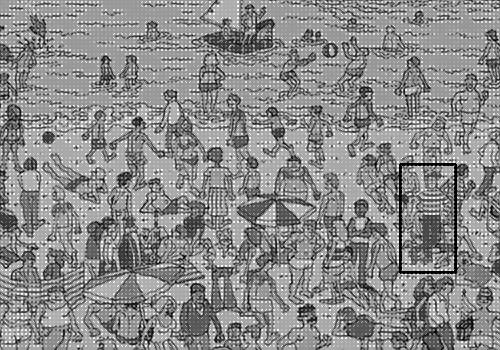

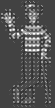


HOG descriptor of the main image:
[0.2947885  0.         0.         ... 0.25490299 0.         0.        ]

HOG descriptor of the charater template:
[0. 0. 0. ... 0. 0. 0.]
17.908992926889695


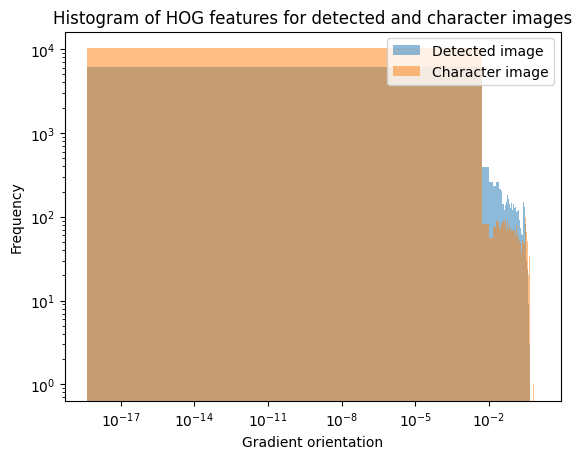


Result:
Predicted bounding box: (400, 164, 455, 272)
Found the character
Correct!
Accuracy: 100.00%
---------------------------------------------------------------------------------
Processing image_100.png
HOG overlay on the main image and character template:


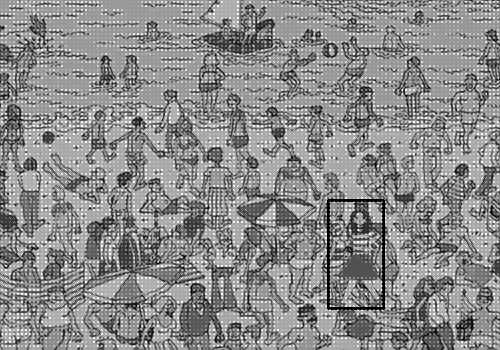

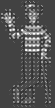


HOG descriptor of the main image:
[0.2947885  0.         0.         ... 0.25490299 0.         0.        ]

HOG descriptor of the charater template:
[0. 0. 0. ... 0. 0. 0.]
19.179025170095205


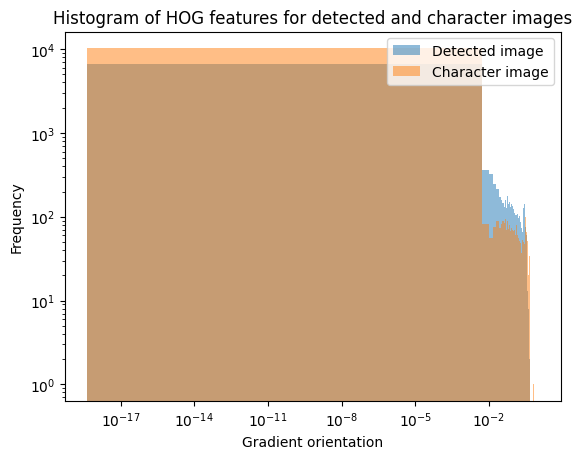

HOG difference: 19.179025170095205 (exceeds threshold)
This is a different character!
Accuracy: 0.00%
---------------------------------------------------------------------------------
Processing image_101.png
HOG overlay on the main image and character template:


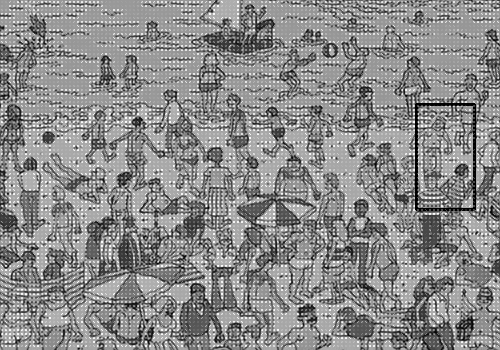

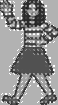


HOG descriptor of the main image:
[0.2947885  0.         0.         ... 0.25490299 0.         0.        ]

HOG descriptor of the charater template:
[0.18772879 0.09763843 0.         ... 0.         0.         0.03776944]
20.26910573893396


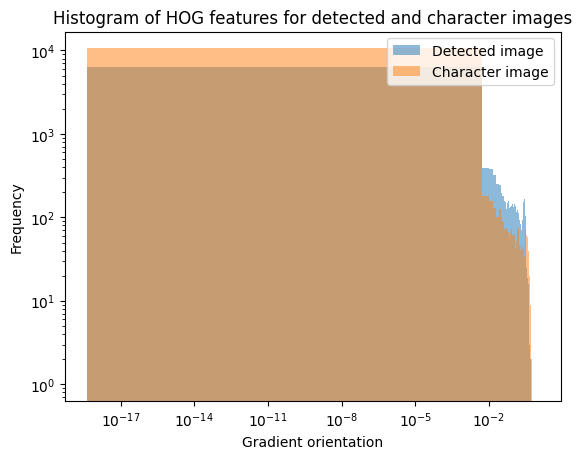

HOG difference: 20.26910573893396 (exceeds threshold)
This is a different character!
Accuracy: 0.00%
---------------------------------------------------------------------------------
Processing image_100.png
HOG overlay on the main image and character template:


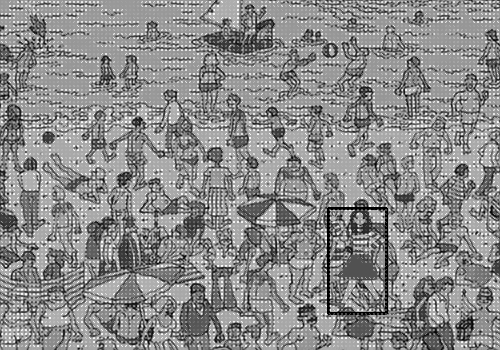

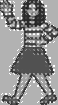


HOG descriptor of the main image:
[0.2947885  0.         0.         ... 0.25490299 0.         0.        ]

HOG descriptor of the charater template:
[0.18772879 0.09763843 0.         ... 0.         0.         0.03776944]
17.945198692892248


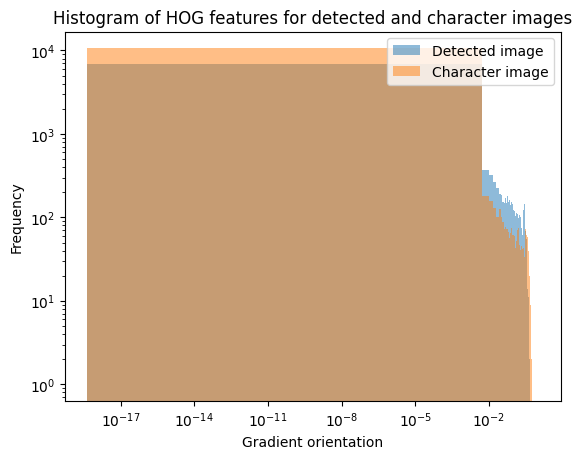


Result:
Predicted bounding box: (328, 208, 386, 313)
Found the character
Correct!
Accuracy: 100.00%


In [ ]:
if __name__ == '__main__':
    for character_template_path in ["/content/drive/MyDrive/project/character/55.png", "/content/drive/MyDrive/project/character/wilma58.png"]:
      for image_folder, ground_truth_bboxes  in [("/content/drive/MyDrive/project/train_waldo/waldo", waldo_ground_truth_bboxes), ("/content/drive/MyDrive/project/train_waldo/wilma", wilma_ground_truth_bboxes)]:
        # Update the HOG parameters here
        hog_params = {
            "orientations": 12,
            "pixels_per_cell": (4,4),
            "cells_per_block": (2,2)
        }

        n = 1 # The number of samples per case
        correct = 0
        total = n

        # Loop through all image files in the specified directory
        for image_file in glob.glob(os.path.join(image_folder, '*.png'))[:n]:
            image_name = os.path.basename(image_file)

            if image_name in ground_truth_bboxes:
                ground_truth_bbox = ground_truth_bboxes[image_name]
                print("---------------------------------------------------------------------------------")
                print(f"Processing {image_name}")  # Print the processing file name

            if find_waldo_hog(image_file, character_template_path, ground_truth_bbox, "gray", hog_diff_threshold=18.5):
              print("Correct!")
              correct += 1

        accuracy = correct / total
        print(f"Accuracy: {accuracy * 100:.2f}%")

        total = len(ground_truth_bboxes)

##Test HOG on color images

---------------------------------------------------------------------------------
Processing image_101.png


<ipython-input-23-1ee96e245749>:8: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,


HOG overlay on the main image and character template:


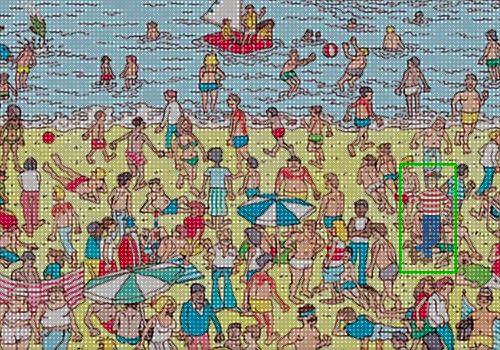

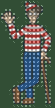


HOG descriptor of the main image:
[0.19688879 0.         0.         ... 0.24454351 0.0853706  0.        ]

HOG descriptor of the charater template:
[0. 0. 0. ... 0. 0. 0.]
17.4030783338912


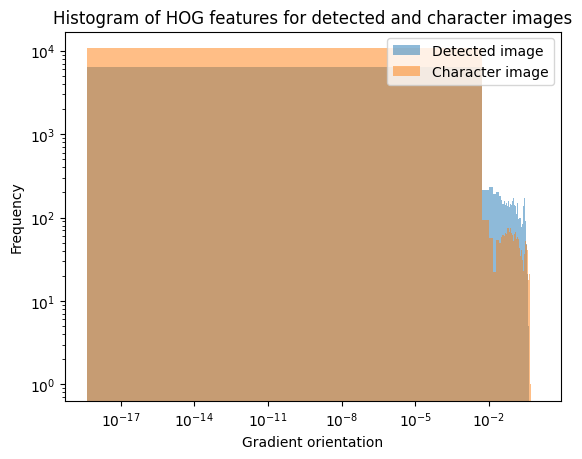


Result:
Predicted bounding box: (400, 164, 455, 272)
Found the character
Correct!
Accuracy: 100.00%
---------------------------------------------------------------------------------
Processing image_100.png
HOG overlay on the main image and character template:


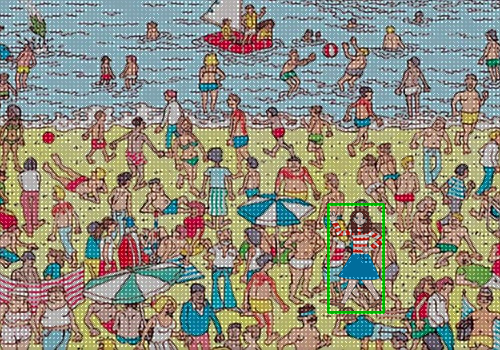

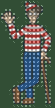


HOG descriptor of the main image:
[0.19688879 0.         0.         ... 0.24454351 0.0853706  0.        ]

HOG descriptor of the charater template:
[0. 0. 0. ... 0. 0. 0.]
19.260645805397562


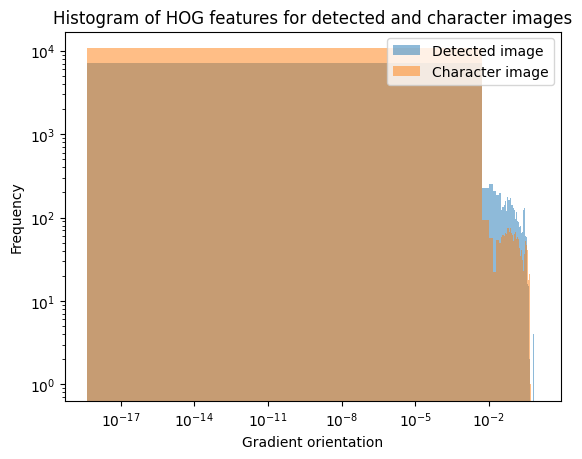

HOG difference: 19.260645805397562 (exceeds threshold)
This is a different character!
Accuracy: 0.00%
---------------------------------------------------------------------------------
Processing image_101.png
HOG overlay on the main image and character template:


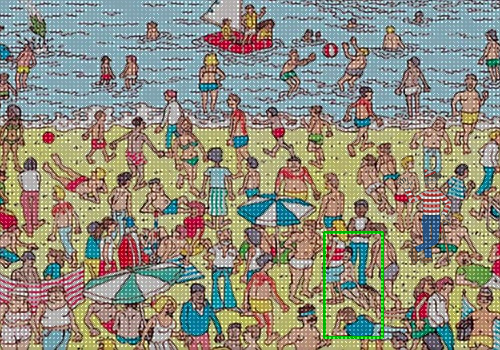

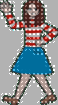


HOG descriptor of the main image:
[0.19688879 0.         0.         ... 0.24454351 0.0853706  0.        ]

HOG descriptor of the charater template:
[0.19309577 0.10055413 0.         ... 0.         0.         0.        ]
20.44063361196416


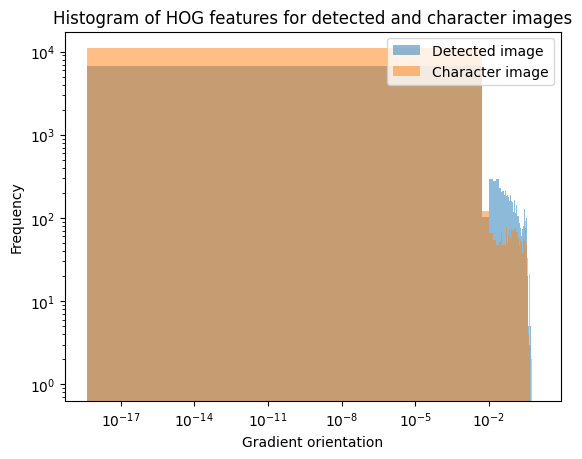

HOG difference: 20.44063361196416 (exceeds threshold)
This is a different character!
Accuracy: 0.00%
---------------------------------------------------------------------------------
Processing image_100.png
HOG overlay on the main image and character template:


In [ ]:
if __name__ == '__main__':
    for character_template_path in ["/content/drive/MyDrive/project/character/55.png", "/content/drive/MyDrive/project/character/wilma58.png"]:
      for image_folder, ground_truth_bboxes  in [("/content/drive/MyDrive/project/train_waldo/waldo", waldo_ground_truth_bboxes), ("/content/drive/MyDrive/project/train_waldo/wilma", wilma_ground_truth_bboxes)]:
        # Update the HOG parameters here
        hog_params = {
            "orientations": 12,
            "pixels_per_cell": (4,4),
            "cells_per_block": (2,2)
        }

        n = 1 # The number of samples per case
        correct = 0
        total = n

        # Loop through all image files in the specified directory
        for image_file in glob.glob(os.path.join(image_folder, '*.png'))[:n]:
            image_name = os.path.basename(image_file)

            if image_name in ground_truth_bboxes:
                ground_truth_bbox = ground_truth_bboxes[image_name]
                print("---------------------------------------------------------------------------------")
                print(f"Processing {image_name}")  # Print the processing file name

            if find_waldo_hog(image_file, character_template_path, ground_truth_bbox, "color", hog_diff_threshold=18.5):
              print("Correct!")
              correct += 1

        accuracy = correct / total
        print(f"Accuracy: {accuracy * 100:.2f}%")

        total = len(ground_truth_bboxes)

##Test SIFT

In [ ]:
if __name__ == '__main__':
    for character_template_path in ["/content/drive/MyDrive/project/character/55.png", "/content/drive/MyDrive/project/character/wilma58.png"]:
      for image_folder, ground_truth_bboxes  in [("/content/drive/MyDrive/project/train_waldo/waldo", waldo_ground_truth_bboxes), ("/content/drive/MyDrive/project/train_waldo/wilma", wilma_ground_truth_bboxes)]:
        # Update the HOG parameters here
        hog_params = {
            "orientations": 12,
            "pixels_per_cell": (4,4),
            "cells_per_block": (2,2)
        }

        n = 1 # The number of samples per case
        correct = 0
        total = n

        # Loop through all image files in the specified directory
        for image_file in glob.glob(os.path.join(image_folder, '*.png'))[:n]:
            image_name = os.path.basename(image_file)

            if image_name in ground_truth_bboxes:
                ground_truth_bbox = ground_truth_bboxes[image_name]
                print("---------------------------------------------------------------------------------")
                print(f"Processing {image_name}")  # Print the processing file name

            if find_waldo_sift(image_file, character_template_path, ground_truth_bbox):
              print("Correct!")
              correct += 1

        accuracy = correct / total
        print(f"Accuracy: {accuracy * 100:.2f}%")

        total = len(ground_truth_bboxes)

Other feature extraction methods we used. But finally these method didn't help:

#K-means

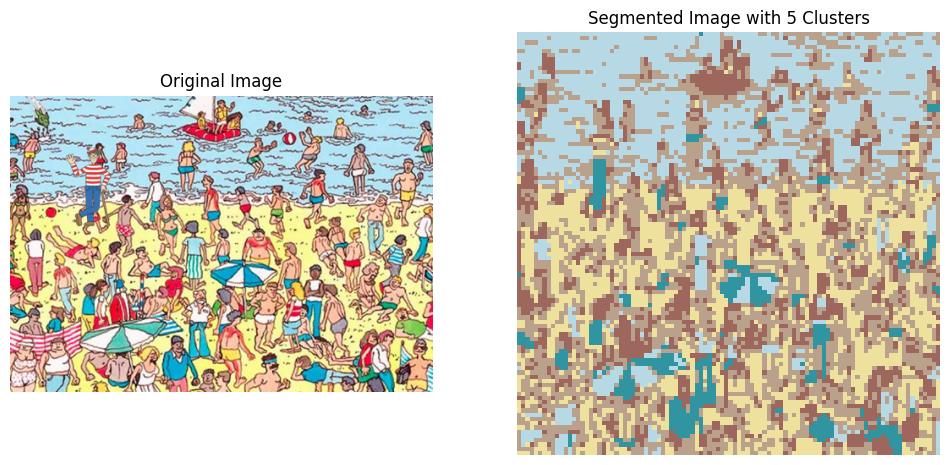

In [ ]:
image_folder = "/content/drive/MyDrive/project/train_waldo/waldo"
image_file = "image_103.png"

image_path = f"{image_folder}/{image_file}"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_resized = cv2.resize(image, (100, 100), interpolation=cv2.INTER_AREA)
image_reshaped = image_resized.reshape(-1, 3)

k = 5 # The number of clusters
n_init_value = 10

kmeans = KMeans(n_clusters=k, n_init=n_init_value)
kmeans.fit(image_reshaped)

segmented_image = kmeans.cluster_centers_[kmeans.labels_]
segmented_image = segmented_image.reshape(image_resized.shape)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(122)
plt.imshow(segmented_image.astype(np.uint8))
plt.title(f"Segmented Image with {k} Clusters")
plt.axis("off")

plt.show()

##PCA

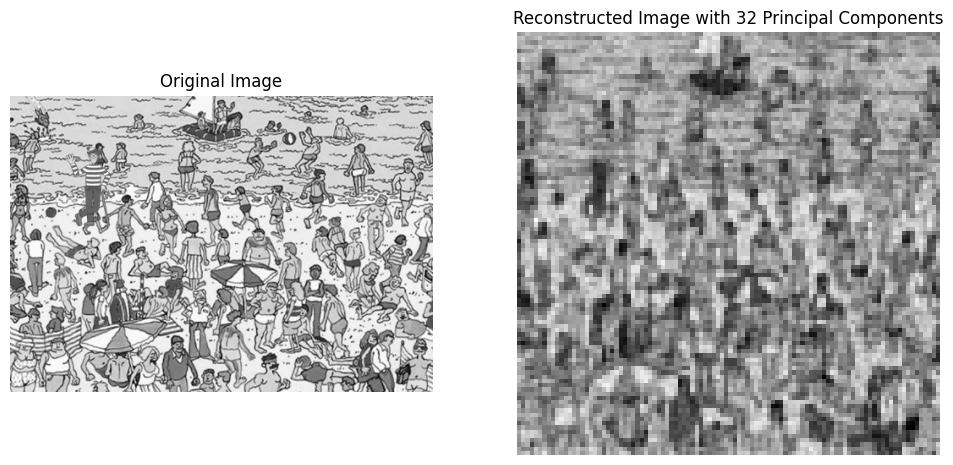

In [ ]:
image_folder = "/content/drive/MyDrive/project/train_waldo/waldo"
image_file = "image_103.png"

image_path = f"{image_folder}/{image_file}"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray_original = cv2.cvtColor(image , cv2.COLOR_RGB2GRAY)

image_resized = cv2.resize(image, (100, 100), interpolation=cv2.INTER_AREA)
image_gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)

n_components = 32 # The number of principal components

pca = PCA(n_components=n_components)
pca.fit(image_gray)

image_pca = pca.transform(image_gray)
image_reconstructed = pca.inverse_transform(image_pca)



plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_gray_original, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(122)
plt.imshow(image_reconstructed, cmap="gray")
plt.title(f"Reconstructed Image with {n_components} Principal Components")
plt.axis("off")

plt.show()